# `House Price Prediction` 

### Main objective:
Goal is to predict the price of the Houses using regression models from the given multible features.



### Plan for data exploration:
1. cleaning data 
    * removing unimportant data 
    * dealing with missing (NaN) values if found
2. feature engineering 
    * visualizing the data and see the data distribution 
    * deal with skewed distribution if found and apply Log transforming on them
3. Variable Selection
    * encoding for categorical variables if found
    * feature scalling for continuous variables
4. Spliting the Data & implementing Cross Validation
    * Train-Test split
    * using k-fold with n=3
5. regression models
    * Linear regression
    * regulation using Ridge and Lasso


In [130]:
# importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline

# understanding the data

In [131]:
df = pd.read_csv('data/housing.csv')
df.shape

(506, 14)

In [132]:
df.head().T

,0,1,2,3,4
CRIM,0.00632,0.02731,0.02729,0.03237,0.06905
ZN,18.00000,0.00000,0.00000,0.00000,0.00000
INDUS,2.31000,7.07000,7.07000,2.18000,2.18000
CHAS,0.00000,0.00000,0.00000,0.00000,0.00000
NOX,0.53800,0.46900,0.46900,0.45800,0.45800
RM,6.57500,6.42100,7.18500,6.99800,7.14700
AGE,65.20000,78.90000,61.10000,45.80000,54.20000
DIS,4.09000,4.96710,4.96710,6.06220,6.06220
RAD,1.00000,2.00000,2.00000,3.00000,3.00000
TAX,296.00000,242.00000,242.00000,222.00000,222.00000


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [134]:
df.dtypes.to_frame().rename(columns={0:'Data Type'})

,Data Type
CRIM,float64
ZN,float64
INDUS,float64
CHAS,int64
NOX,float64
RM,float64
AGE,float64
DIS,float64
RAD,int64
TAX,float64


In [135]:
# dealing with missing values
df.isnull().sum().sort_values(ascending= False)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [136]:
#unique values
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns],
    columns=['Variable', 'Unique Values']).set_index('Variable')
# df_uniques
df_uniques.sort_values(by=['Unique Values'],ascending=False)


,Unique Values
Variable,
CRIM,504
LSTAT,455
RM,446
DIS,412
B,357
AGE,356
MEDV,229
NOX,81
INDUS,76


### Log transforming skewed variables

In [137]:
# Create a list of float colums to check for skewing
mask = df.dtypes == float
float_cols = df.columns[mask]

skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = df[float_cols].skew()

In [138]:
# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

,Skew
CRIM,5.223149
ZN,2.225666
MEDV,1.108098
DIS,1.011781
LSTAT,0.906460
PTRATIO,-0.802325
B,-2.890374


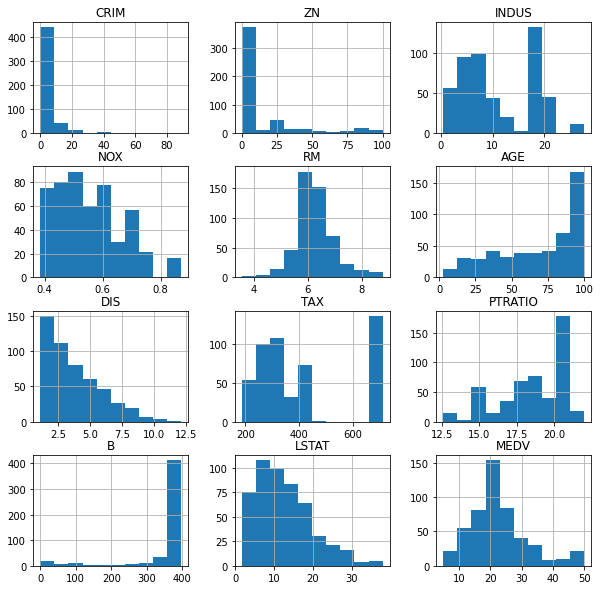

In [139]:
viz = df[float_cols]
viz.hist(figsize=(10,10))
plt.show()

In [140]:
# Perform the skew transformation:

for col in skew_cols.index.values:
    df[col] = df[col].apply(np.log1p)

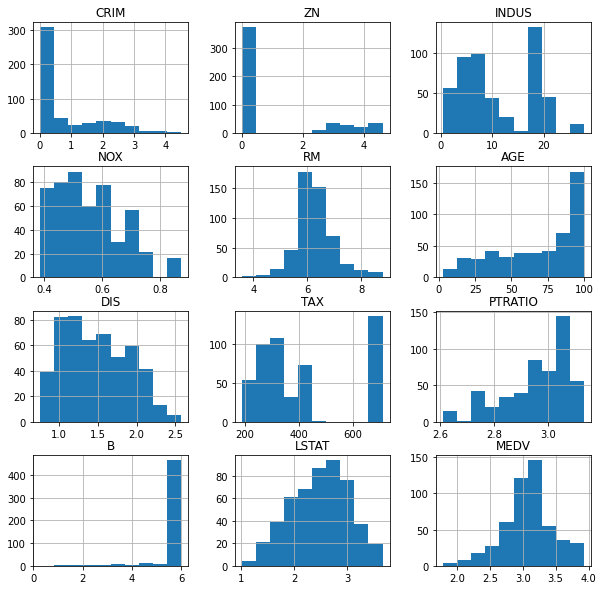

In [141]:
viz = df[float_cols]
viz.hist(figsize=(10,10))
plt.show()

Now, let's plot each of these features against MEDV, to see how linear their relationship is:

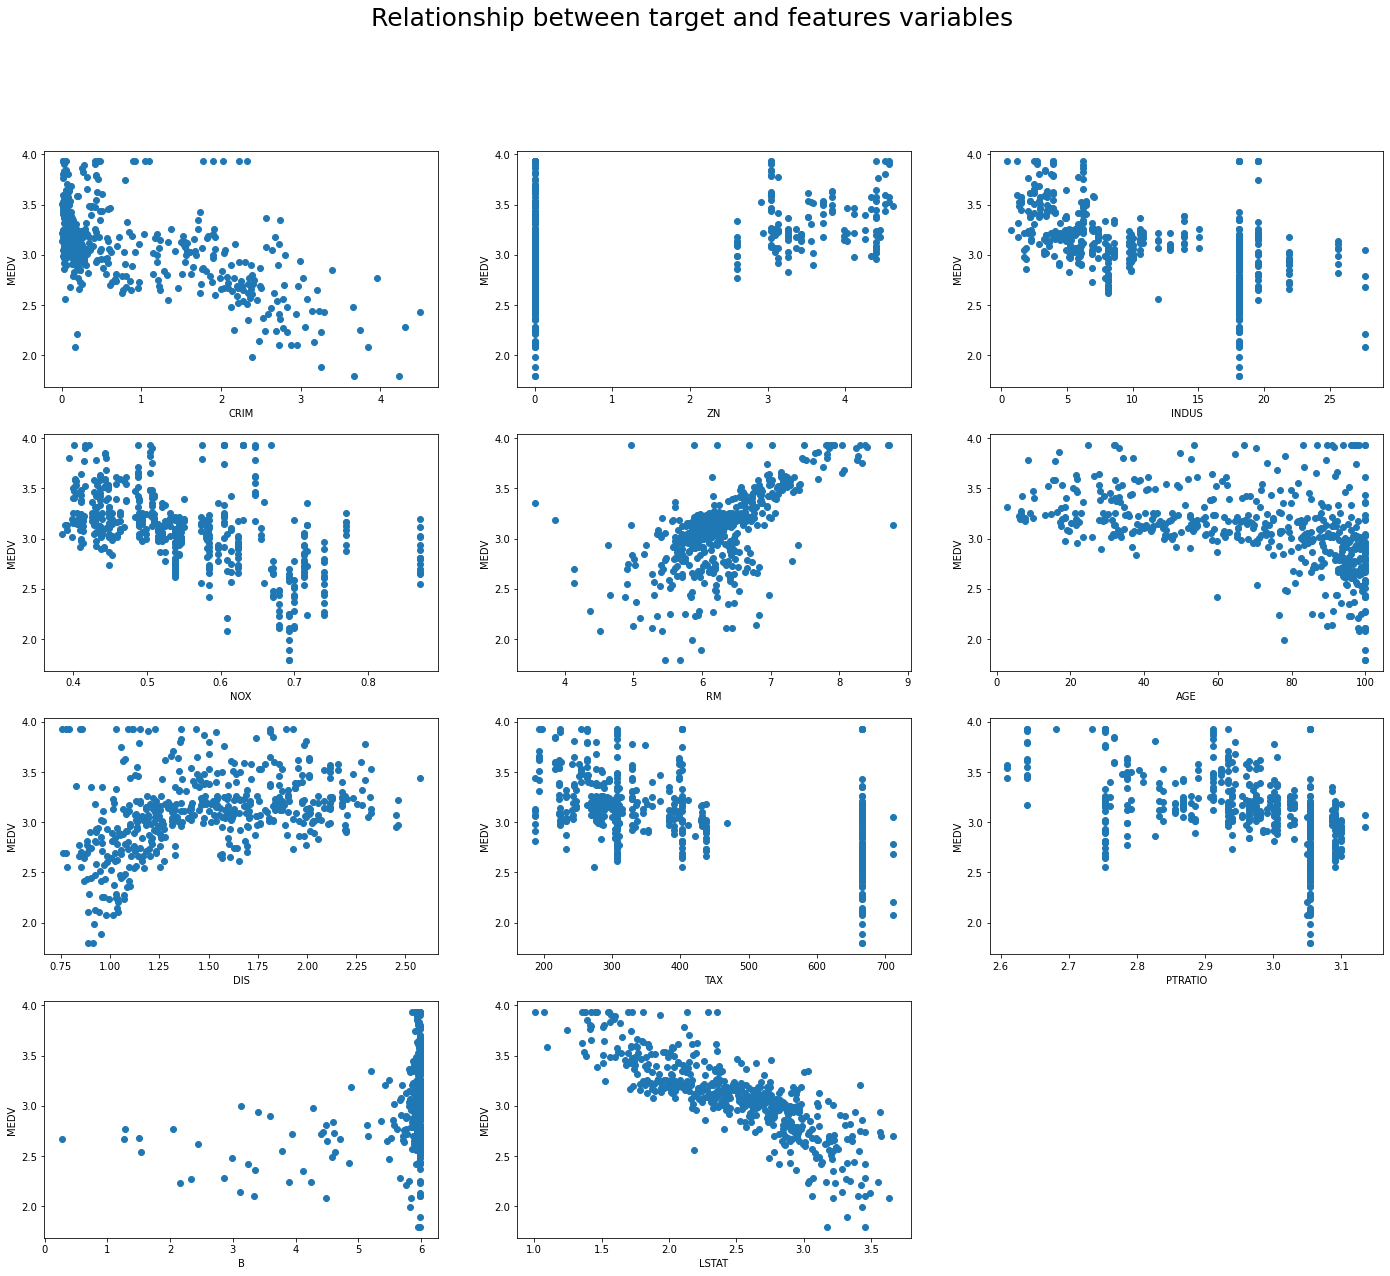

In [142]:
plt.figure(figsize=(24,20))
plt.suptitle('Relationship between target and features variables', size=25)

for var , i in zip(float_cols,np.arange(1,len(float_cols))):
    # if var == 'MEDV':
    #     continue
    plt.subplot(4,3,i)
    plt.scatter(df[var], df.MEDV)
    plt.xlabel(f"{var.upper()}")
    plt.ylabel("MEDV")


In [143]:
corr = df.corr()

Text(0.5, 1.0, 'Heatmap for all variables')

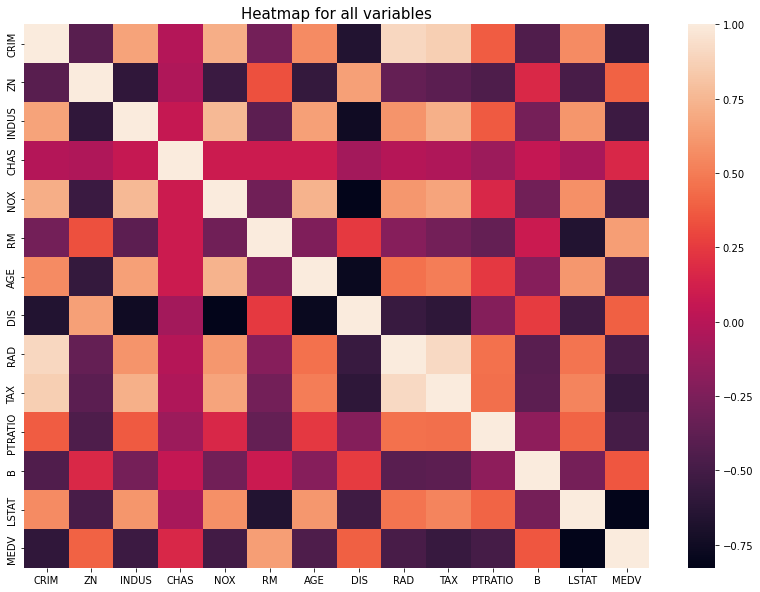

In [144]:
plt.figure(figsize=(14,10))
sns.heatmap(corr)
plt.title('Heatmap for all variables', size=15)

### spliting data

In [145]:
X = df.drop('MEDV', axis=1)
y = df.MEDV
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=72018)

### scaling


In [146]:
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.fit_transform(X_test)


In [147]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

### Regression Model with k-fold

In [148]:
# First: LinearRegression
lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_pred = lr.predict(X_test_s)
linear_r2 = r2_score(y_test, y_pred)


In [149]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)


In [150]:
scores = []

for train_index, test_index in kf.split(df):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test)
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test, y_pred)
    
    scores.append(score)

scores

[0.7935329739961079, 0.7790263883838388, 0.7825648630149404]

### Add Polynomial Features to Pipeline and use Grid Search CV

In [151]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("lasso_regression", Lasso())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'lasso_regression__alpha': np.geomspace(0.06, 6.0, 20)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [152]:
grid = grid.fit(X, y)


In [153]:
grid.best_score_, grid.best_params_

(0.7483939820323983,
 {'lasso_regression__alpha': 0.06, 'polynomial_features__degree': 3})

In [154]:
y_predict = grid.predict(X)
lasso_r2 = r2_score(y, y_predict)
print(f'lasso_r2 = {lasso_r2}')
lasso_rmse = rmse(y, y_predict)
print(f'lasso_rmse = {lasso_rmse}')
lasso_mae = mean_absolute_error(y, y_predict)
print(f'lasso_mae = {lasso_mae}')
lasso_mse = mean_squared_error(y, y_predict)
print(f'lasso_mse = {lasso_mse}')

lasso_r2 = 0.7760757133303235
lasso_rmse = 0.18293358127694911
lasso_mae = 0.1364661222763316
lasso_mse = 0.03346469515881015


### Ridge

In [155]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(0.06, 6.0, 20)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [156]:
grid = grid.fit(X, y)

In [157]:
grid.best_score_, grid.best_params_


(0.8610108831204987,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 4.708559822108766})

In [158]:
y_predict = grid.predict(X)
r2_score(y, y_predict)

0.916872254221221

In [159]:
linear_reg_rmse = rmse(y_test, y_pred)
print(linear_reg_rmse)

linear_mae = mean_absolute_error(y_test, y_pred)
print(linear_mae)

linear_mse = mean_squared_error(y_test, y_pred)
print(linear_mse)

0.16866103996061563
0.1268147202563806
0.02844654640059638


In [160]:

y_predict = grid.predict(X)
ridge_r2 = r2_score(y, y_predict)
print(f'ridge_r2 = {ridge_r2}')
ridge_rmse = rmse(y, y_predict)
print(f'ridge_rmse = {ridge_rmse}')
ridge_mae = mean_absolute_error(y, y_predict)
print(f'ridge_mae = {ridge_mae}')
ridge_mse = mean_squared_error(y, y_predict)
print(f'ridge_mse = {ridge_mse}')


ridge_r2 = 0.916872254221221
ridge_rmse = 0.11145917873970608
ridge_mae = 0.07868868693913844
ridge_mse = 0.012423148525329749


In [161]:
rmse_vals = [linear_reg_rmse, ridge_rmse, lasso_rmse]
r2_vals = [linear_r2, ridge_r2, lasso_r2]
mae_vals = [linear_mae, ridge_mae, lasso_mae]
mse_vals = [linear_mse, ridge_mse, lasso_mse]

labels = ['Linear', 'Ridge', 'Lasso']

metrics = {'MAE': mae_vals, 'MSE': mse_vals, 'RMSE': rmse_vals, 'R^2': r2_vals}
metrics_df = pd.DataFrame(metrics, index=labels)

metrics_df

,MAE,MSE,RMSE,R^2
Linear,0.126815,0.028447,0.168661,0.801900
Ridge,0.078689,0.012423,0.111459,0.916872
Lasso,0.136466,0.033465,0.182934,0.776076


# `Conclusion`
This analysis shows that feature engineering can have a large effect on the model performance, and if the data are sufficiently large, cross-validation should be preferred over train-test-split to construct model evaluation. In my case, even though the predictors have high multicollinearity, their coefficients were not shrunk by the Lasso model, and it is shown that regularization does not always make big improvement on a given model. In the end, the Lasso regression has the highest $R^2$ when predicting on the test set, and categories of car model appear to be the most important features to predict houses prices. Also, Lasso did shrink some of the features that are not so important in terms of prediction.